# Preproc

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
df = pd.read_csv('../../../raw_data/2011_2021_caluire_phys_v0.csv')
df = df[['DatePrel', '1340']]
df['DatePrel'] = pd.to_datetime(df['DatePrel'])
df['month'] = df['DatePrel'].dt.month
df['year'] = df['DatePrel'].dt.year
df.groupby(['year', 'month'], as_index = False).mean()
df['date'] = pd.to_datetime(dict(year = df.year, month = df.month, day = 1), format = '%Y%m')
df = df.drop(columns = ['DatePrel', 'month', 'year'])
df = df.set_index('date')
df = df.rename(columns = {'1340' : 'nitrates'})
df = df.groupby(['date']).mean()
df = df.asfreq(freq = 'MS', method = 'pad')
df

,nitrates
date,
2011-11-01,11.1
2011-12-01,11.1
2012-01-01,13.0
2012-02-01,13.0
2012-03-01,10.6
...,...
2021-04-01,10.5
2021-05-01,9.1
2021-06-01,8.9


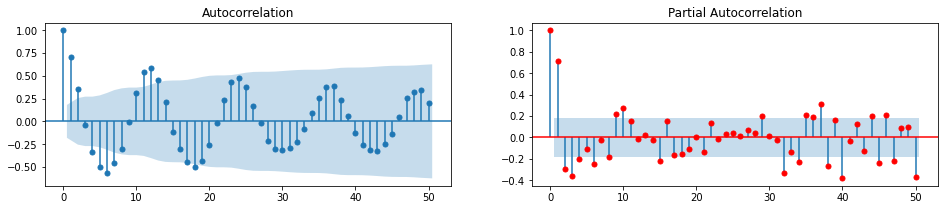

In [33]:
# ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df.nitrates, lags=50, ax=axes[0]);
plot_pacf(df.nitrates, lags=50, ax=axes[1], color='r');

In [34]:
result_mul = seasonal_decompose(df['nitrates'], model = 'multiplicative', period = 12)

In [35]:
def differentials(df):
    zero_diff = df.nitrates
    first_order_diff = df.nitrates.diff(1)
    second_order_diff = df.nitrates.diff(1).diff(1)
    return zero_diff, first_order_diff, second_order_diff
    
def plot_differentials(df):
    
    diffs = differentials(df)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    ax1.plot(diffs[0]); ax1.set_title('Original Series')
    ax2.plot(diffs[1]); ax2.set_title('1st Order Differencing')
    ax3.plot(diffs[2]); ax3.set_title('2nd Order Differencing');
    
def deseasonalized(df):
    df['deseasonalized'] = df.nitrates.values/result_mul.seasonal
    df['linearized'] = np.log(df['deseasonalized'])
    return df['deseasonalized'], df['linearized']

def plot_deseasonalized(df):
    deseason = deseasonalized(df)
    plt.figure(figsize=(15,4));
    plt.subplot(1,2,1); plt.plot(deseason[0]);
    plt.title('Deseasonalized', fontsize=16);
    plt.subplot(1,2,2); plt.plot(deseason[1])
    plt.title('Deseasonalized and Linearized', fontsize=16);

In [36]:
train = deseasonalized(df)[1][:89]
test = deseasonalized(df)[1][89:]

# Model

In [37]:
p, d, q = 3, 1, 2

In [38]:
arima = ARIMA(train, order=(p,d,q)).fit()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48545D-01    |proj g|=  3.93148D+00

At iterate    5    f= -1.51073D-01    |proj g|=  1.40822D-01

At iterate   10    f= -1.51630D-01    |proj g|=  1.33989D+00

At iterate   15    f= -1.52215D-01    |proj g|=  1.87212D-03

At iterate   20    f= -1.52232D-01    |proj g|=  9.76112D-02

At iterate   25    f= -1.52239D-01    |proj g|=  2.27596D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     34      1     0     0   

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


In [39]:
arima.summary()

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.linearized   No. Observations:                   88
Model:                 ARIMA(3, 1, 2)   Log Likelihood                  13.397
Method:                       css-mle   S.D. of innovations              0.203
Date:                Wed, 24 Nov 2021   AIC                            -12.794
Time:                        17:02:14   BIC                              4.547
Sample:                    12-01-2011   HQIC                            -5.808
                         - 03-01-2019                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0030      0.002     -1.485      0.138      -0.007       0.001
ar.L1.D.linearized    -0.2614      0.107     -2.453      0.014      -0.470      -0.053
ar.L2.D.linearized     0.5662      0.098      5.777      0.000       0.374       0.758
ar.L3.D.linearized    -0.0975      0.110     -0.887      0.375      -0.313       0.118
ma.L1.D.linearized -4.888e-08        nan        nan        nan         nan         nan
ma.L2.D.linearized    -1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0434           +0.0000j            1.0434            0.5000
AR.2            2.0457           +0.0000j            2.0457            0.0000
AR.3            4.8038           +0.0000j            4.8038            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

In [40]:
forecast, std_err, confidence_int = arima.forecast(len(test), alpha=0.05)

In [41]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

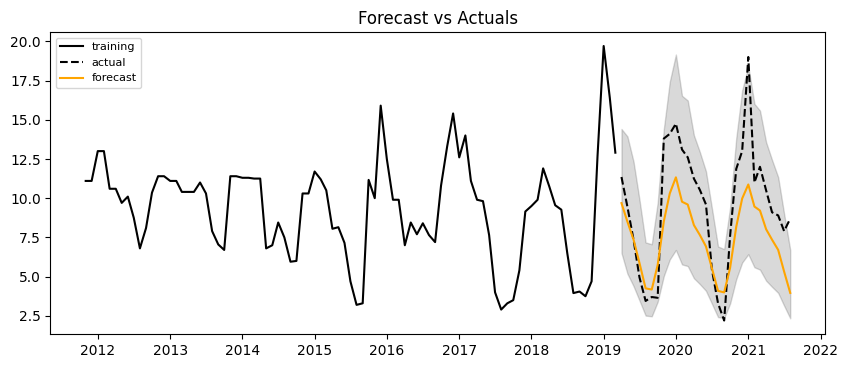

In [42]:
forecast_recons = np.exp(forecast)*result_mul.seasonal[89:]
train_recons = np.exp(train)*result_mul.seasonal[:89]
test_recons = np.exp(test)*result_mul.seasonal[89:]
lower_recons = np.exp(confidence_int)[:,0]*result_mul.seasonal[89:]
upper_recons = np.exp(confidence_int)[:,1]*result_mul.seasonal[89:]

# plt 
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)

In [43]:
result_mul.seasonal

date
2011-11-01    1.087450
2011-12-01    1.351420
2012-01-01    1.456588
2012-02-01    1.289200
2012-03-01    1.242494
                ...   
2021-04-01    1.098821
2021-05-01    0.998218
2021-06-01    0.923217
2021-07-01    0.727338
2021-08-01    0.548372
Freq: MS, Name: seasonal, Length: 118, dtype: float64